In [16]:
import io
import os
import platform
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

In [17]:
data=pd.read_csv('beijing.csv')
dataset=data.iloc[:,-1]
dataset.replace(9999,np.nan,inplace=True)
dataset.replace(-999,np.nan,inplace=True)
for i in range(len(data)):
    if np.isnan(dataset.iat[i]):
        if i==0:
            dataset.iloc[i]=dataset.iat[i+1]
        elif i==len(data)-1:
            dataset.iloc[i]=dataset.iat[i-1]
        else:
            dataset.iloc[i]=np.nanmean([dataset.iat[i-1],dataset.iat[i+1]])

In [18]:
type(dataset)

pandas.core.series.Series

In [19]:
scaler = preprocessing.MinMaxScaler() 
scaled_values = scaler.fit_transform(pd.DataFrame(dataset))
# dataset.iloc[:] = np.squeeze(scaled_values)

In [37]:
data_set=np.asarray(dataset,dtype=np.float32)
seq_len=30 + 1
x=len(data_set)-seq_len
sequences = [data_set[t:t+seq_len] for t in range(x)]
for i in range(len(sequences)):
    sequences[i]=scaler.fit_transform(sequences[i].reshape(-1,1))

In [38]:
seq=torch.FloatTensor(sequences)

In [39]:
split_row=round(0.90*seq.size(0))
x_train_set=seq[:split_row, :-1]
y_train_set=seq[:split_row, -1]
x_valid_set=seq[split_row:, :-1]
y_valid_set=seq[split_row:, -1]

In [40]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=2,dropout=0,bidirectional=False):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.dropout=dropout
        self.bidirectional=bidirectional
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self,inputs,hidden):
        outputs,hidden=self.lstm(inputs,hidden)
        predictions=self.linear(outputs[-1])
        return predictions,outputs,hidden
    
    def init_hidden(self,batch_size):
        num_directions=2 if self.bidirectional else 1
        hidden = (torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size))
        return hidden

In [41]:
def get_batch(x,y,i,batch_size):
    if x.dim() == 2:
        x = x.unsqueeze(2)
    batch_x = x[(i*batch_size):(i*batch_size)+batch_size, :, :]
    batch_y = y[(i*batch_size):(i*batch_size)+batch_size]

    # Reshape Tensors into (seq_len, batch_size, input_size) format for the LSTM.
    batch_x = batch_x.transpose(0, 1)
    
    return batch_x, batch_y

In [45]:
def train(model,x_train_set,y_train_set,optimizer,batch_size,epoch):
    num_sequences=x_train_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.train()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_train_set, y_train_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data
        
    print("Epoch {}: Loss = {:.8f}".format(epoch+1, total_loss/num_batches))
    return total_loss/num_batches

In [46]:
def eval(model,x_valid_set,y_valid_set,optimizer,batch_size):
    num_sequences=x_valid_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.eval()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_valid_set, y_valid_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data

    print("Validation: Loss = {:.8f}".format(total_loss/num_batches))
    return total_loss/num_batches

In [47]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'beijing.pt'
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

Training model for 30 epoch
Epoch 1: Loss = 0.11686194
Validation: Loss = 0.06273371
Epoch 2: Loss = 0.05175854
Validation: Loss = 0.03934131
Epoch 3: Loss = 0.03320352
Validation: Loss = 0.03239310
Epoch 4: Loss = 0.02734287
Validation: Loss = 0.03151133
Epoch 5: Loss = 0.02583459
Validation: Loss = 0.03173966
Epoch 6: Loss = 0.02551331
Validation: Loss = 0.03178328
Epoch 7: Loss = 0.02540181
Validation: Loss = 0.03170137
Epoch 8: Loss = 0.02532654
Validation: Loss = 0.03160591
Epoch 9: Loss = 0.02526393
Validation: Loss = 0.03152598
Epoch 10: Loss = 0.02520860
Validation: Loss = 0.03145985
Epoch 11: Loss = 0.02515857
Validation: Loss = 0.03140466
Epoch 12: Loss = 0.02511213
Validation: Loss = 0.03135969
Epoch 13: Loss = 0.02506759
Validation: Loss = 0.03132587
Epoch 14: Loss = 0.02502352
Validation: Loss = 0.03130424
Epoch 15: Loss = 0.02497840
Validation: Loss = 0.03129637
Epoch 16: Loss = 0.02493059
Validation: Loss = 0.03130946
Epoch 17: Loss = 0.02487843
Validation: Loss = 0.0313

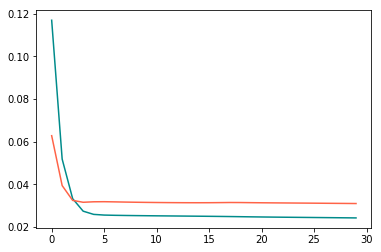

In [48]:
input_size=1
hidden_size=24
num_layers=2
lstm=LSTM(input_size,hidden_size)

learning_rate=0.0001
max_grad_norm=5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=0.00001)

batch_size = 8
num_epochs = 30 #3
# num_sequences = x_train_set.size(0)
# num_batches = num_sequences //batch_size

checkpoint_freq = 10
path = './'

train_losses=[]
valid_losses=[]

print("Training model for {} epoch".format(num_epochs))
for epoch in range(num_epochs):
#     total_loss = 0

    # Shuffle input and target sequences.
    idx = torch.randperm(x_train_set.size(0))
    x = x_train_set[idx]
    y = y_train_set[idx]
    
    train_loss=train(lstm,x_train_set,y_train_set,optimizer,batch_size,epoch)
    valid_loss=eval(lstm,x_valid_set,y_valid_set,optimizer,batch_size)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, lstm, path)
        
# Last checkpoint
save_model(num_epochs, lstm, path)
    
print("\n\n\nOptimization ended.\n")

plt.plot(train_losses, color="darkcyan", label="train")
plt.plot(valid_losses, color="tomato",label="validation")
plt.show()

In [49]:
def predict_one_hour(model,x_valid_set,input_size,num_steps):
    predictions=torch.zeros(num_steps)
    for i, x in enumerate(x_valid_set):
        hidden=model.init_hidden(1)
        y_pred,_,_=model(x.contiguous().view(-1, 1, input_size),hidden)
        predictions[i]=y_pred
    return predictions

In [50]:
one_step_predictions = predict_one_hour(lstm, x_valid_set, input_size, y_valid_set.size(0))

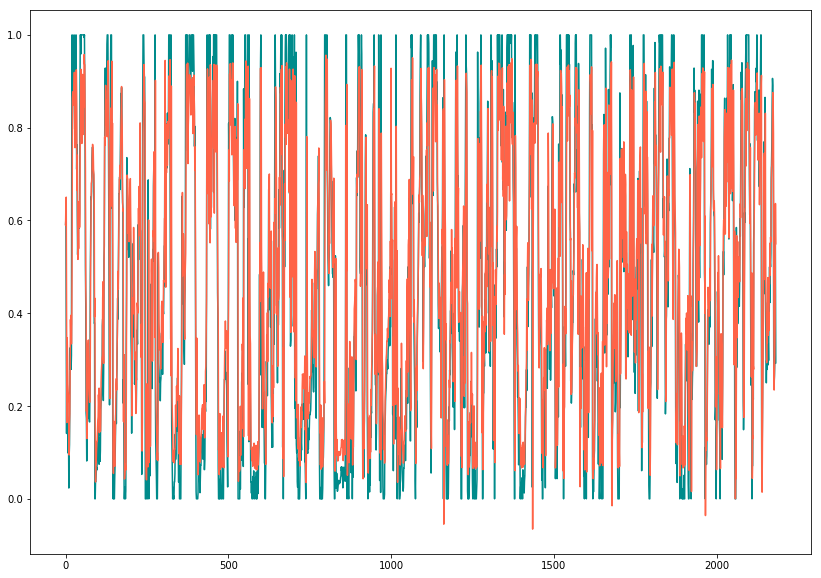

In [52]:
fig = plt.figure(figsize=(14, 10))
plt.plot(y_valid_set.data.numpy(),color='darkcyan')
plt.plot(one_step_predictions.data.numpy(),color='tomato')
plt.show()